# Taxi Demand-Supply Gap Prediction #

## Load Packages ##

In [1]:
import pandas as pd
import numpy as np
import json, gc
import matplotlib.pyplot as plt

## Load & Inspect Data ##

In [2]:
data_dir = "/home/lee/Documents/DatasetsForGitHub/Taxi_Trajectory_Prediction/"

### GPS Coordinates and Paths ###

First check the range of the GPS coordinates. Load the file in chunks to avoid using too much memory. 

In [3]:
def gen_thru_dataset(input_df):
    return pd.read_csv(data_dir+input_df,
                   chunksize=10000,
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)})
    
check_coordinates = gen_thru_dataset('train.csv')

lat_min_l = []
lon_min_l = []
lat_max_l = []
lon_max_l = []

for chunk in check_coordinates:

    latlon = np.array([(lat, lon) 
                       for path in chunk['POLYLINE']
                       for lon, lat in path if len(path) > 0])

    lat_min, lon_min = np.nanmin(latlon, axis=0)
    lat_max, lon_max = np.nanmax(latlon, axis=0)  
     
    lat_min_l.append(lat_min)
    lon_min_l.append(lon_min)
    lat_max_l.append(lat_max)
    lon_max_l.append(lon_max)
    
print("minimum latitude: {}".format(min(lat_min_l)))
print("maximum latitude: {}".format(max(lat_max_l)))
print("minimum longitude: {}".format(min(lon_min_l)))
print("maximum longitude: {}".format(max(lon_max_l)))

gc.collect()

minimum latitude: 31.992111
maximum latitude: 51.037119
minimum longitude: -36.913779
maximum longitude: 52.900803


14

The region formed by these coordinates is profoundly larger than Porto. We constrain the scope of this project to Porto, which we approximate with the latitude and longitude bounds below. In addition, longitude -36.913779 between the above latitude bounds is oceanic; this discovery brings the integrity of GPS records into question.

In [4]:
del check_coordinates, lat_min, lat_max, lon_min, lon_max, latlon, lat_min_l, lon_min_l, lat_max_l, lon_max_l

lat_min, lat_max = 41.04961, 41.24961
lon_min, lon_max = -8.71099, -8.51099

Now we produce a heatmap of the taxi paths.

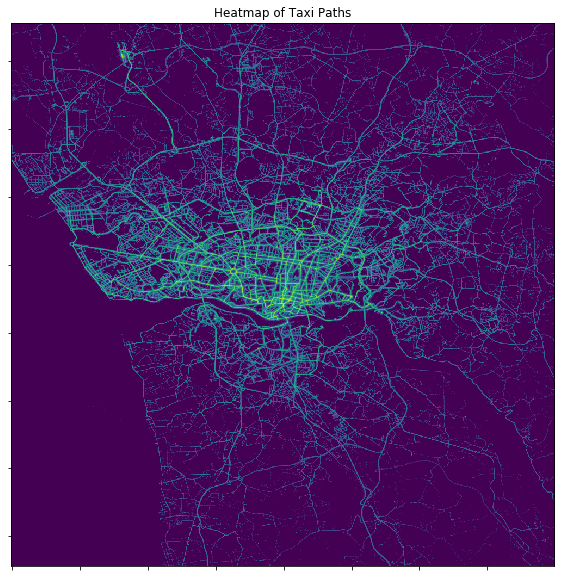

2396

In [5]:
bins = 1000
z = np.zeros((bins, bins))

# run the generator again to restart the generation
data = gen_thru_dataset('train.csv')

for chunk in data:

    latlon = np.array([(lat, lon) 
                       for path in chunk['POLYLINE']
                       for lon, lat in path if len(path) > 0])

    z += np.histogram2d(*latlon.T, bins=bins, 
                        range=[[lat_min, lat_max],
                               [lon_min, lon_max]])[0]
        
log_density = np.log(1+z)

fig, ax = plt.subplots(figsize=(10, 10))

fig = plt.imshow(log_density[::-1,:], # flip vertically to suit map display
           extent=[lat_min, lat_max, lon_min, lon_max])

plt.title('Heatmap of Taxi Paths')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

del latlon, z, log_density, fig, ax, bins, data
gc.collect()

### Check Missing ###

In [25]:
df = pd.read_csv(data_dir+"train.csv").drop('POLYLINE', axis=1)
df['start_time'] = pd.to_datetime(df['TIMESTAMP'], unit='s')

In [7]:
print("Proportion of missing data of each field in the dataset:")
df.isnull().mean()

Proportion of missing data of each field in the dataset:


TRIP_ID         0.000000
CALL_TYPE       0.000000
ORIGIN_CALL     0.786768
ORIGIN_STAND    0.528501
TAXI_ID         0.000000
TIMESTAMP       0.000000
DAY_TYPE        0.000000
MISSING_DATA    0.000000
start_time      0.000000
dtype: float64

### Construct Features ###

We treat the starting location and time of a taxi trip as demand, as they correspond to a rider request. The end of a trip is treated as supply as it represents an available taxi.

We first extract supply data. 

In [26]:
# extract end locations of each taxi trip
taxi_end = pd.read_csv(data_dir+"train.csv",
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)[-1:]})

taxi_end.rename(columns={"POLYLINE": "end_loc"}, inplace=True)

add_end = pd.concat([df, taxi_end], axis=1, sort=False)

supply = add_end.sort_values(by=['TAXI_ID', 'start_time'])

We use the starting time of one taxi's next trip as an approximation of its current trip's end time. A taxi is available as of this left-censored end time. Left censorship leads to an underestimation of taxi availability. 

If the next trip's starting time is more than 16 hours apart from the current trip's starting time, we set the current trip's end time to null.  

In [27]:
supply['end_time'] = supply['start_time'].shift(-1)

supply.loc[(supply['TAXI_ID'] != supply.shift(-1)['TAXI_ID']) 
           | ((supply['end_time'] - supply['start_time']).astype('timedelta64[h]') > 16), 'end_time'] = pd.NaT

supply.sort_index(inplace=True)

supply.drop(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TIMESTAMP',\
             'DAY_TYPE', 'MISSING_DATA', 'start_time'], axis=1, inplace=True)

# handle the trips that do not have any GPS records
supply['end_lon'] = supply['end_loc'].apply(lambda x: x[0][0] if len(x)>0 else np.nan)
supply['end_lat'] = supply['end_loc'].apply(lambda x: x[0][1] if len(x)>0 else np.nan)

# limit to Porto
supply_local = supply[(supply['end_lat']>=lat_min) & (supply['end_lat']<=lat_max) \
                      & (supply['end_lon']>=lon_min) & (supply['end_lon']<=lon_max)].copy()

Now we extract demand data.

In [28]:
# start locations of each trip
taxi_start = pd.read_csv(data_dir+"train.csv",
                   usecols=['POLYLINE'],
                   converters={'POLYLINE': lambda x: json.loads(x)[0:1]})
taxi_start.rename(columns={"POLYLINE": "start_loc"}, inplace=True)

demand = pd.concat([df, taxi_start], axis=1, sort=False)

demand.drop(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TIMESTAMP',\
             'DAY_TYPE', 'MISSING_DATA'], axis=1, inplace=True)

demand['start_lon'] = demand['start_loc'].apply(lambda x: x[0][0] if len(x)>0 else np.nan)
demand['start_lat'] = demand['start_loc'].apply(lambda x: x[0][1] if len(x)>0 else np.nan)

demand_local = demand[(demand['start_lat']>=lat_min) & (demand['start_lat']<=lat_max) \
                      & (demand['start_lon']>=lon_min) & (demand['start_lon']<=lon_max)].copy()

In [29]:
del df, taxi_end, add_end, supply, taxi_start, demand
gc.collect()

42

We extract week, day of week, hour and minute information as separate features for the prediction. Later we will group demand and supply into 30-minute time windows. 

In [30]:
# timestamp to week, day, hour, and minute
demand_local['week'] = demand_local['start_time'].dt.week
demand_local['dayofweek'] = demand_local['start_time'].dt.dayofweek
demand_local['hour'] = demand_local['start_time'].dt.hour
demand_local['minute'] = demand_local['start_time'].dt.minute

supply_local['week'] = supply_local['end_time'].dt.week
supply_local['dayofweek'] = supply_local['end_time'].dt.dayofweek
supply_local['hour'] = supply_local['end_time'].dt.hour
supply_local['minute'] = supply_local['end_time'].dt.minute

We geospatially bucket the data using a bucket size of 1/100th degree latitude by 1/100th degree longitude (approximately 0.84 km by 1.1 km). 

In [31]:
demand_local['lon_localized'] = np.floor((demand_local['start_lon']-lon_min) * 100)
demand_local['lat_localized'] = np.floor((demand_local['start_lat']-lat_min) * 100)

supply_local['lon_localized'] = np.floor((supply_local['end_lon']-lon_min) * 100)
supply_local['lat_localized'] = np.floor((supply_local['end_lat']-lat_min) * 100)

We further bucket the data chronologically. 

In [32]:
demand_pvt = demand_local.pivot_table(['TAXI_ID'], index=['week', 'dayofweek', 'hour', 'minute', 'lon_localized', \
                                                    'lat_localized'], aggfunc='count', fill_value=0)

demand_pvt.rename(columns={'TAXI_ID': 'demand'}, inplace=True)

supply_pvt = supply_local.pivot_table(['TAXI_ID'], index=['week', 'dayofweek', 'hour', 'minute', 'lon_localized', \
                                                    'lat_localized'], aggfunc='count', fill_value=0)

supply_pvt.rename(columns={'TAXI_ID': 'supply'}, inplace=True)

Calculate the gap between demand and supply. Note that a positive gap corresponds to unmet demand. 

In [33]:
gap = demand_pvt.join(supply_pvt, how='outer').fillna(0).reset_index()
gap['gap'] = gap['demand'] - gap['supply']

Define the duration of the time window. 

In [34]:
time_slice = 30 # in minutes

Bucket data into time windows. 

In [35]:
gap['time_window'] = np.floor((gap['hour']*60 + gap['minute'])/time_slice)

grid = gap.groupby(by=['week', 'dayofweek', 'time_window', 'lon_localized', 'lat_localized'], \
                 as_index=False)['demand', 'supply', 'gap'].sum()

In [39]:
del gap, demand_local, supply_local, demand_pvt, supply_pvt

gc.collect()

84

We represent time/location with no taxi trips with zeros. 

In [36]:
all_week = sorted(grid['week'].unique().tolist())
all_dayofweek = sorted(grid['dayofweek'].unique().tolist())
all_time_window = sorted(grid['time_window'].unique().tolist())
all_lon_grid = sorted(grid['lon_localized'].unique().tolist())
all_lat_grid = sorted(grid['lat_localized'].unique().tolist())

dummy_index = pd.MultiIndex.from_product([all_week, all_dayofweek, all_time_window, all_lon_grid, all_lat_grid],
                             names=['week', 'dayofweek', 'time_window', 'lon_localized', 'lat_localized'])

dummy = pd.DataFrame(index=dummy_index, columns=['demand', 'supply', 'gap'])
dummy.fillna(0, inplace=True)
dummy.reset_index(inplace=True)

del dummy_index

dummy.update(grid)

In [37]:
grid_filled = dummy.copy()
del dummy

gc.collect()

21

For each time window, the predictive target is the gap in the subsequent time window. 

In [38]:
forecast_period = 1

grid_filled = grid_filled.sort_values(by=['lon_localized', 'lat_localized', 'week', 'dayofweek', 'time_window'])
grid_filled['gap_forecast'] = grid_filled['gap'].shift(-forecast_period)
grid_filled = grid_filled.drop('gap', axis=1)

Regarding features, we include the demand/supply/time information of the current time window as well as six time windows back. 

In [40]:
# 6 time windows back as features
grid_filled['demand_tm1'] = grid_filled['demand'].shift(periods=1) # t-1
grid_filled['demand_tm2'] = grid_filled['demand'].shift(periods=2)
grid_filled['demand_tm3'] = grid_filled['demand'].shift(periods=3)
grid_filled['demand_tm4'] = grid_filled['demand'].shift(periods=4)
grid_filled['demand_tm5'] = grid_filled['demand'].shift(periods=5)
grid_filled['demand_tm6'] = grid_filled['demand'].shift(periods=6)

grid_filled['supply_tm1'] = grid_filled['supply'].shift(periods=1)
grid_filled['supply_tm2'] = grid_filled['supply'].shift(periods=2)
grid_filled['supply_tm3'] = grid_filled['supply'].shift(periods=3)
grid_filled['supply_tm4'] = grid_filled['supply'].shift(periods=4)
grid_filled['supply_tm5'] = grid_filled['supply'].shift(periods=5)
grid_filled['supply_tm6'] = grid_filled['supply'].shift(periods=6)

grid_filled.fillna(0, inplace=True)
grid_filled.reset_index(drop=True)
grid_filled.sort_values(by=['week', 'dayofweek', 'time_window', 'lon_localized', 'lat_localized'], inplace=True)

In [ ]:
gc.collect()

Split data into training and testing datasets.

In [42]:
train_size = int(0.8 * len(grid_filled))

df_train = grid_filled[:train_size]
df_test = grid_filled[train_size:]

del train_size

df_train.to_pickle(data_dir+"train.pkl")
df_test.to_pickle(data_dir+"test.pkl")